In [1]:
import keras
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jon/data/sandbox/keras/ve/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Following the Variational Autoencoder (VAE) example at https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [5]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [6]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [7]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [8]:
from keras.utils import plot_model

In [10]:
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

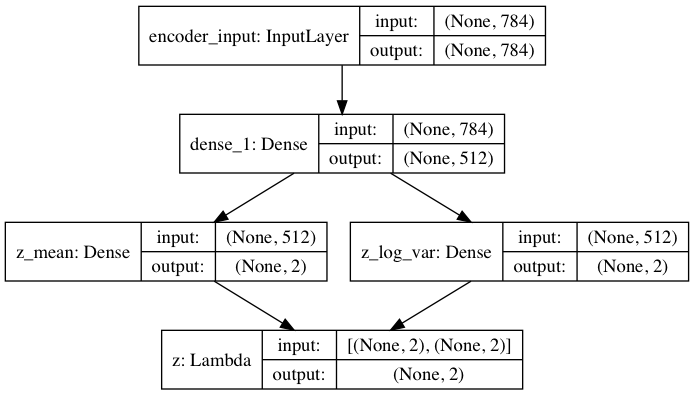

In [13]:
from IPython.display import Image
display(Image('vae_mlp_encoder.png'))

In [14]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


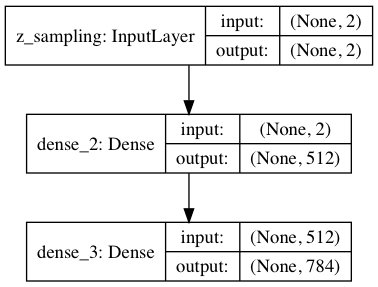

In [15]:
display(Image('vae_mlp_decoder.png'))

In [16]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [17]:
models = (encoder, decoder)
data = (x_test, y_test)
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


/Users/jon/data/sandbox/keras/ve/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  # Remove the CWD from sys.path while we load stuff.


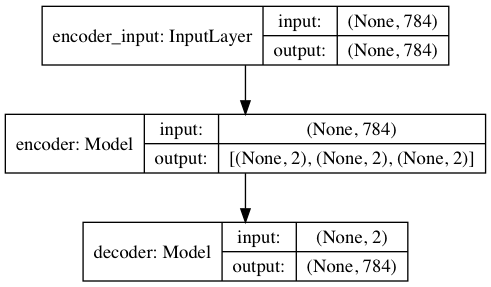

In [18]:
display(Image('vae_mlp.png'))

In [19]:
vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 94us/step - loss: 196.5163 - val_loss: 171.9913
Epoch 2/50
60000/60000 [==============================] - 5s 86us/step - loss: 168.5394 - val_loss: 166.1861
Epoch 3/50
60000/60000 [==============================] - 5s 86us/step - loss: 165.0153 - val_loss: 164.1348
Epoch 4/50
60000/60000 [==============================] - 5s 87us/step - loss: 163.0500 - val_loss: 162.5032
Epoch 5/50
60000/60000 [==============================] - 5s 88us/step - loss: 161.5066 - val_loss: 160.9974
Epoch 6/50
60000/60000 [==============================] - 5s 86us/step - loss: 160.1302 - val_loss: 159.9688
Epoch 7/50
60000/60000 [==============================] - 5s 89us/step - loss: 158.8729 - val_loss: 158.6483
Epoch 8/50
60000/60000 [==============================] - 5s 87us/step - loss: 157.6248 - val_loss: 157.7317
Epoch 9/50
60000/60000 [==============================] - 5s 91us/step - loss:

Text(0,0.5,'z[1]')

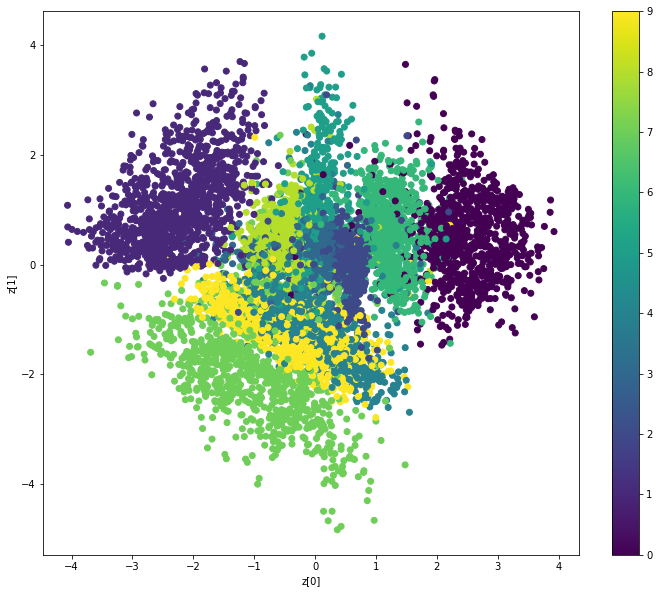

In [20]:
z_mean, _, _ = encoder.predict(x_test,batch_size=batch_size)

In [21]:
import pandas as pd

In [25]:
d = pd.DataFrame( {'x':z_mean[:,0],'y':z_mean[:,1],'label':y_test} )

In [26]:
import seaborn as sns

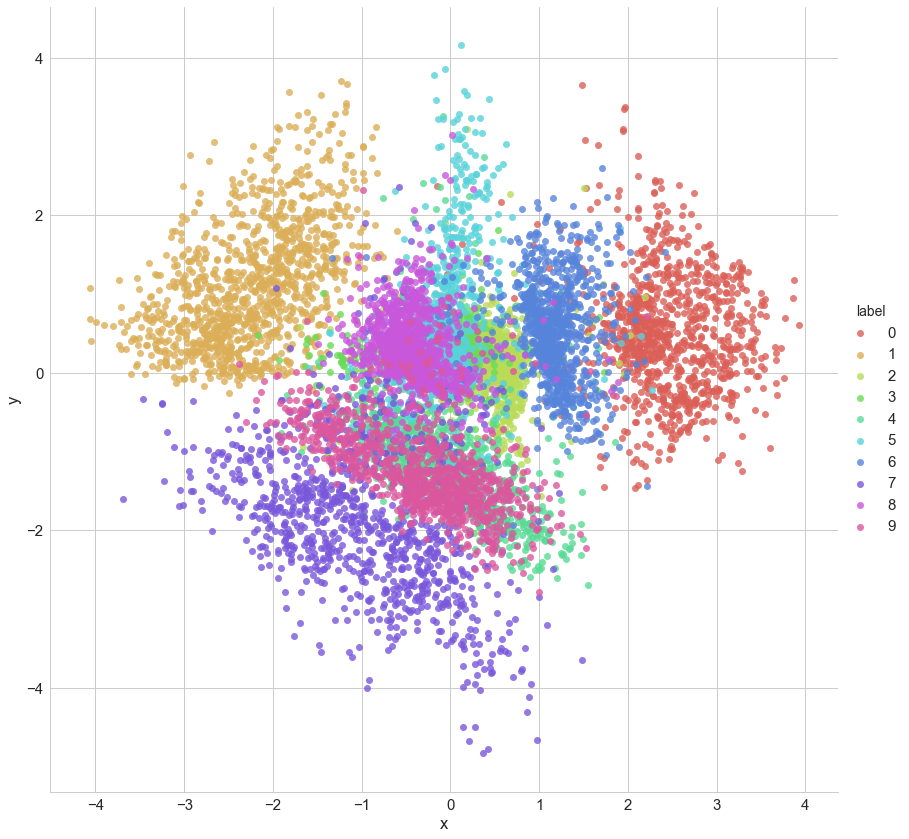

In [47]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set_context('notebook',font_scale=1.5)
sns.set_style('whitegrid')
with sns.color_palette('hls',10):
    sns.lmplot(x="x",y="y",data=d,hue='label',fit_reg=False,size=12)

In [48]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

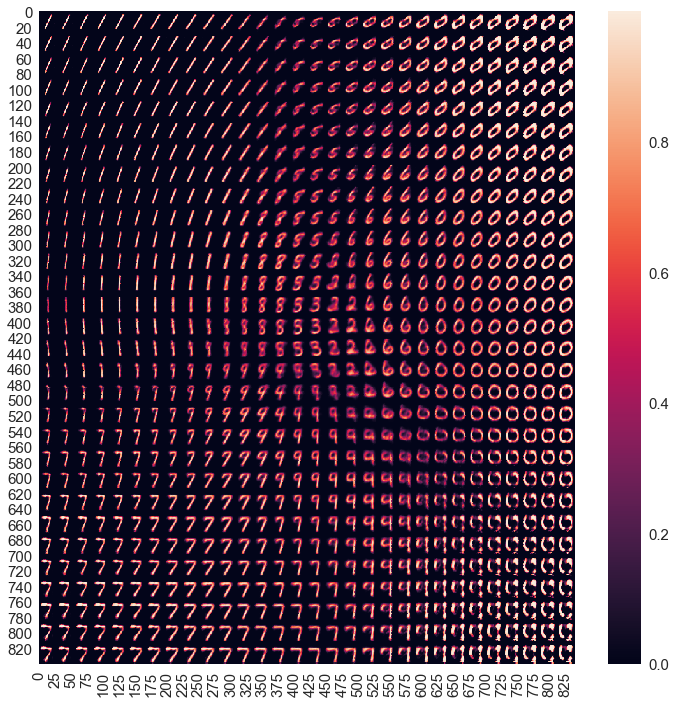

In [52]:
sns.heatmap(figure,xticklabels='auto')